In [6]:
from typing import Callable, Tuple

from keras.datasets import mnist

from matplotlib import pyplot as plt
import numpy as np

import sklearn.preprocessing
import sklearn.metrics

from tqdm import tqdm

# Наши разработки из 3-ей работы))
from nn import Nums
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax
from nn.optimizers import AdamOptimizer, OptimizerBase, NoOptimizer, RMSPropOptimizer

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

2024-12-10 10:22:16.413229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733815336.433280   49961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733815336.439257   49961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 10:22:16.459159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загружаем датасет, one-hot-encoding для меток классов

In [7]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x / 255
test_x = test_x / 255

train_x.resize(60000, 784)
test_x.resize(10000, 784)

encoder = sklearn.preprocessing.OneHotEncoder()
train_y = encoder.fit_transform(train_y[..., None]).toarray()
test_y = encoder.fit_transform(test_y[..., None]).toarray()

train_x.shape, train_y.shape

((60000, 784), (60000, 10))

In [8]:
def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
    return np.pad(x, ((padding[1], padding[1]), (padding[0], padding[0])))

def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
    """2д свёртка

    Args:
        x (Nums): Входной массив, 2d
        filters (Nums): Ядра свёртки, 3d
        strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

    Returns:
        Nums: Результат свёртки
    """
    if padding != (0, 0):
        x = add_padding(x, padding)
    
    output_shape = (np.subtract(x.shape, filters.shape[-2:]) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    views_shape = output_shape + filters.shape[-2:]
    
    row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
        )
    return np.einsum('ijkl, qkl -> qij', views, filters)

In [9]:
# for i in range(len(train_x)):
#     y = conv2d(train_x[i].reshape((28, 28)), w, strides=(1, 1), padding=(1, 1))

In [10]:
def get_views(x: Nums, window: Tuple[int, int], strides: Tuple[int, int]) -> Nums:
    output_shape = (np.subtract(x.shape, window) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    views_shape = output_shape + window
    
    row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
    )
    return views
    

In [11]:
def space_matrix(x, strides):
    shape_x, shape_y = x.shape[-2:]
    shape_x = (shape_x - 1) * strides[0] + 1
    shape_y = (shape_y - 1) * strides[1] + 1
    new_x = np.zeros((x.shape[:-2] + (shape_x, shape_y)))
    new_x[..., ::strides[0], ::strides[1]] = x
    return new_x

In [12]:
class MaxPool2DLayer:
    def __init__(
        self,
        window: Tuple[int, int],
        strides: Tuple[int, int],
        input_shape: Tuple[int, int, int]
    ) -> None:
        self.window = window
        self.strides = strides
        self.num_filters_in = input_shape[0]
        self.input_shape = input_shape

        output_shape = (np.subtract(input_shape[1:], window) + strides) / strides
        self.output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
        self._calced = None

    def forward(self, x: Nums) -> Nums:
        # x - размерность [NumFilters x M x N]
        
        t = []
        calced = []
        
        for i in range(len(x)):
            views = get_views(x[i], self.window, self.strides)
            out = np.max(views, axis=(-2, -1))
            t.append(out)
            calced.append(views)
        
        t = np.array(t).reshape((x.shape[0], *self.output_shape))
        self._calced = calced
        return t
        
    def backward(self, error: Nums) -> Nums:
        # error - размерность [NumFilters x M x N]
        views = self._calced
        self._calced = None

        out = np.zeros(self.input_shape)
        
        for k in range(len(error)):
            de_dX_i_views = get_views(out[k], window=self.window, strides=self.strides)   
            
            views_i = views[k]

            for i in range(views_i.shape[-4]):
                for j in range(views_i.shape[-3]):
                    max_index = np.argmax(views_i[i, j])
                    de_dX_i_views[i, j][np.unravel_index(max_index, views_i.shape[-2:])] += error[k, i, j]
            
        return out

    def update(self, learning_rate: float):
        pass

    def set_optimizer(self, optimizer: OptimizerBase):
        pass

    def __repr__(self) -> str:
        return f"<Pooling2dLayer>"


In [13]:
arr = np.arange(25).reshape(1, 5, 5)
arr = np.random.randint(1, 30, (1, 5, 5))
display(arr)
pool = MaxPool2DLayer((3, 3), (1, 1), (1, 5, 5))
fwd = pool.forward(arr)
display(fwd)

pool.backward(np.ones_like(fwd))

array([[[28, 20,  2, 12, 12],
        [14, 26, 11, 25, 12],
        [21,  6,  4, 12, 22],
        [15, 21, 15,  8, 14],
        [27,  8,  9, 13, 17]]])

array([[[28, 26, 25],
        [26, 26, 25],
        [27, 21, 22]]])

array([[[1.000, 0.000, 0.000, 0.000, 0.000],
        [0.000, 3.000, 0.000, 2.000, 0.000],
        [0.000, 0.000, 0.000, 0.000, 1.000],
        [0.000, 1.000, 0.000, 0.000, 0.000],
        [1.000, 0.000, 0.000, 0.000, 0.000]]])

In [ ]:
from functools import reduce
from operator import mul


class Conv2DLayer:
    """
    Реализует свёрточный слой

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения

    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        filters_shape: Tuple[int, int, int],
        strides: Tuple[int, int],
        padding: Tuple[int, int],
        activation_function: Tuple[
            NumsToNums,
            NumsToNums,
        ],
        shape: Tuple[int, int],
        weights_initialize_function: Callable[[Tuple[int, int]], Nums] = None,
    ) -> None:
        if weights_initialize_function is None:
            weights_initialize_function = np.random.random

        self.num_filters = filters_shape[0]
        self.weights = weights_initialize_function(filters_shape)
        self.bias = weights_initialize_function(filters_shape)
        self.activation_function = activation_function[0]
        self.activation_function_derivation = activation_function[1]
        self.strides = strides
        self.padding = padding
        self.input_shape = shape
        self.input_shape_ravel = reduce(mul, shape)
        
        output_shape = (np.subtract(shape, filters_shape[-2:]) + strides) / strides
        self.output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))

        # Значения x и t, фиксируемые при forward, нужны для вычисления ошибки
        self.cache = None
        self._errors_log = ([], [])

    def forward(self, x: Nums) -> Nums:
        # x - размерность [NumFilters x M x N]
    
        t = []
        
        t = np.zeros((self.num_filters, *self.output_shape))
        
        for i in range(len(x)):
            out = conv2d(x[i], self.weights, strides=self.strides, padding=self.padding)
            t.append(out)
        
        t = np.array(t).reshape((x.shape[0] * self.num_filters, *self.output_shape))
        h = self.activation_function(t)
        self.cache = (x, t)
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        x, t = self.cache
        
        # (5, 28, 28)
        
        de_dT = error * self.activation_function_derivation(t)
        
        de_dX = []
        # print(x.shape, de_dT.shape, self.weights.shape, error.shape)
        # (2, 12, 12) (4, 10, 10) (2, 3, 3) (4, 10, 10)
        # (8, 8, 3, 3) (10, 10)
        # weights_flipped = self.weights[..., ::-1, ::-1].copy()
        
        de_dW = np.zeros(self.weights.shape)
        de_dX = np.zeros(x.shape)
        
        for i in range(len(x)):
            views = get_views(add_padding(x[i], self.padding), self.weights.shape[1:], self.strides)
            for j in range(self.num_filters):
                de_dW[j] += np.einsum('ijkl, ij -> kl', views, de_dT[j * len(x) + i])
                
                rotated = np.flip(de_dT[j * len(x) + i], (-2, -1))
                spaced = space_matrix(rotated, self.strides)
                
                padding = tuple(np.subtract(spaced.shape[-2:], 1))
                
                convolved = conv2d(self.weights[j], spaced[None, :], (1, 1), padding)
                # print(de_dX.shape, convolved)
                de_dX[i] += convolved.reshape(x.shape[-2:])
                
        self._errors_log[0].append(de_dW)
        return de_dX

    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        de_dWs, _ = self._errors_log
        de_dW = np.sum(de_dWs, axis=0)
        # de_dB = np.sum(de_dBs, axis=0)

        self.optimizer.step(self.weights, 0, learning_rate, de_dW, 0)

        self._errors_log = ([], [])

    def set_optimizer(self, optimizer: OptimizerBase):
        optimizer.init_params(self.weights, self.bias)
        self.optimizer = optimizer

    def __repr__(self) -> str:
        return f"<Conv2dLayer, {self.weights.shape}>"


In [15]:
q = np.arange(3 * 3).reshape(3, 3)
display(q)

error = np.ones((3, 3))
error[0, 1] = 4
error[2, 1] = 3
display(error)
display(add_padding(q, (1, 1)))

views = get_views(add_padding(q, (1, 1)), (3, 3), (1, 1))
display(views.shape)

np.einsum('ijkl, ij -> kl', views, error)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

array([[1.000, 4.000, 1.000],
       [1.000, 1.000, 1.000],
       [1.000, 3.000, 1.000]])

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0],
       [0, 3, 4, 5, 0],
       [0, 6, 7, 8, 0],
       [0, 0, 0, 0, 0]])

(3, 3, 3, 3)

array([[14.000, 23.000, 22.000],
       [33.000, 53.000, 49.000],
       [29.000, 45.000, 39.000]])

In [16]:
space_matrix(error, (3, 3))

array([[1.000, 0.000, 0.000, 4.000, 0.000, 0.000, 1.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [1.000, 0.000, 0.000, 1.000, 0.000, 0.000, 1.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [1.000, 0.000, 0.000, 3.000, 0.000, 0.000, 1.000]])

In [17]:
weights = np.random.randint(1, 10, size=(3, 3))
display(weights)

error = np.arange(4).reshape((1, 2, 2)) + 1
filters = space_matrix(error, (2, 2))
display(filters)

conv2d(weights, filters, (1, 1), (2, 2))

array([[1, 7, 8],
       [1, 4, 2],
       [8, 1, 8]])

array([[[1.000, 0.000, 2.000],
        [0.000, 0.000, 0.000],
        [3.000, 0.000, 4.000]]])

array([[[4.000, 28.000, 35.000, 21.000, 24.000],
        [4.000, 16.000, 11.000, 12.000, 6.000],
        [34.000, 18.000, 73.000, 10.000, 32.000],
        [2.000, 8.000, 5.000, 4.000, 2.000],
        [16.000, 2.000, 24.000, 1.000, 8.000]]])

In [18]:
filters = space_matrix(np.arange(100).reshape((1, 10, 10)), (1, 1))

conv2d(weights, filters, (1, 1), (9, 9))

array([[[99.000, 791.000, 1575.000, 1559.000, 1543.000, 1527.000,
         1511.000, 1495.000, 1479.000, 1463.000, 1358.000, 720.000],
        [188.000, 1205.000, 2102.000, 2079.000, 2056.000, 2033.000,
         2010.000, 1987.000, 1964.000, 1941.000, 1750.000, 820.000],
        [960.000, 1958.000, 3538.000, 3498.000, 3458.000, 3418.000,
         3378.000, 3338.000, 3298.000, 3258.000, 2358.000, 1440.000],
        [860.000, 1738.000, 3138.000, 3098.000, 3058.000, 3018.000,
         2978.000, 2938.000, 2898.000, 2858.000, 2058.000, 1260.000],
        [760.000, 1518.000, 2738.000, 2698.000, 2658.000, 2618.000,
         2578.000, 2538.000, 2498.000, 2458.000, 1758.000, 1080.000],
        [660.000, 1298.000, 2338.000, 2298.000, 2258.000, 2218.000,
         2178.000, 2138.000, 2098.000, 2058.000, 1458.000, 900.000],
        [560.000, 1078.000, 1938.000, 1898.000, 1858.000, 1818.000,
         1778.000, 1738.000, 1698.000, 1658.000, 1158.000, 720.000],
        [460.000, 858.000, 1538.000, 149

In [19]:
np.array([
    np.arange(2 * 3 * 3).reshape(2, 3, 3),
    np.ones((2, 3, 3))
]).reshape((4, 3, 3))

array([[[0.000, 1.000, 2.000],
        [3.000, 4.000, 5.000],
        [6.000, 7.000, 8.000]],

       [[9.000, 10.000, 11.000],
        [12.000, 13.000, 14.000],
        [15.000, 16.000, 17.000]],

       [[1.000, 1.000, 1.000],
        [1.000, 1.000, 1.000],
        [1.000, 1.000, 1.000]],

       [[1.000, 1.000, 1.000],
        [1.000, 1.000, 1.000],
        [1.000, 1.000, 1.000]]])

In [20]:
class FlattenLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, x: Nums) -> Nums:
        return x.reshape((1, x.size))
    
    def backward(self, error: Nums) -> Nums:
        return error.reshape(self.input_size)
    
    def set_optimizer(self, optimizer):
        pass
    
    def update(self, lr):
        pass

In [21]:
from nn.functions import relu, drelu

# conv1 = Conv2DLayer((5, 3, 3), (1, 1), (1, 1), (relu, drelu), (28, 28))
# pool1 = MaxPool2DLayer((2, 2), (2, 2), (28, 28))
# # conv2 = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14))
# flat1 = FlattenLayer((5, 14, 14))
# mnn1 = Layer(5 * 14 * 14, 10, (softmax, lambda x: x),
#     weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)



conv1 = Conv2DLayer((2, 5, 5), (1, 1), (0, 0), (relu, drelu), (28, 28))
pool1 = MaxPool2DLayer((2, 2), (2, 2), (24, 24))
conv2 = Conv2DLayer((2, 3, 3), (1, 1), (0, 0), (sigmoid, dsigmoid), (12, 12))
pool2 = MaxPool2DLayer((2, 2), (2, 2), (10, 10))
flat1 = FlattenLayer((4, 5, 5))
mnn1 = Layer(4 * 5 * 5, 10, (softmax, lambda x: x),
    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
)



the_y = train_x[0].reshape((1, 28, 28))

true_y = train_y[0]

print(the_y.shape)

conv1_t = the_y
the_y = conv1.forward(the_y)
print(the_y.shape)

the_y = pool1.forward(the_y)
print(the_y.shape)

the_y = conv2.forward(the_y)
print(the_y.shape)

the_y = pool2.forward(the_y)
print(the_y.shape)

the_y = flat1.forward(the_y)
print(the_y.shape)

the_y = mnn1.forward(the_y)
print(the_y.shape)

print("Backwards")

error = the_y - true_y

grad_mnn = mnn1.backward(error)
print("mnn", grad_mnn.shape)

grad_unflatten = flat1.backward(grad_mnn)
print("unflatten", grad_unflatten.shape)

grad_pool2 = pool2.backward(grad_unflatten)
print("pool2", grad_pool2.shape)

de_dW2 = conv2.backward(grad_pool2)
print("conv2", de_dW2.shape)

grad_pool1 = pool1.backward(de_dW2)
print("pool1", grad_pool1.shape)

de_dW1 = conv1.backward(grad_pool1)
print("conv1", de_dW1.shape)
# the_y = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14)).forward(the_y)
# print(the_y.shape)

(1, 28, 28)
(2, 24, 24)
(2, 12, 12)
(4, 10, 10)
(4, 5, 5)
(1, 100)
(1, 10)
Backwards
mnn (1, 100)
unflatten (4, 5, 5)


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax

In [ ]:
# expected 95%
from sklearn.metrics import root_mean_squared_error


network = NN(
    [
        # MaxPool2DLayer((2, 2), (2, 2), (24, 24)),
        # Conv2DLayer((3, 3, 3), (1, 1), (0, 0), (sigmoid, dsigmoid), (28, 28)),
        Conv2DLayer((3, 5, 5), (1, 1), (0, 0), (relu, drelu), (28, 28),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        MaxPool2DLayer((2, 2), (2, 2), (3, 24, 24)),
        
        Conv2DLayer((3, 3, 3), (1, 1), (0, 0), (relu, drelu), (12, 12),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        
        MaxPool2DLayer((2, 2), (2, 2), (9, 10, 10)),
        
        FlattenLayer((9, 5, 5)),
        
        # FlattenLayer((1, 28, 28)),
        # Layer(784, 64, (relu, drelu), weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,),
        Layer(9 * 5 * 5, 10, (softmax, lambda x: x),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
        ),
    ],
    loss_function=cross_entropy,
)

loss_history = []

In [ ]:
network.forward(train_x[:1].reshape((1, 28, 28)))

array([[0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100,
        0.100]])

In [ ]:
def train(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)

        # size - размер выборки для эпохи, ставлю 1000, чтобы быстрее видеть результат
        indices = np.random.choice(len(xy_indices), size=100, replace=False)

        epoch_x = x[indices]
        epoch_y = y[indices]
        
        network.train(
            epoch_x,
            epoch_y,
            lambda: RMSPropOptimizer(0.4),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )
        
        # Средний loss за эпоху
        loss = network.pop_loss(np.mean)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history


loss_history = train(
    network, train_x.reshape((60000, 1, 28, 28)), train_y, 250, 0.005, 25, loss_history
)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 19, loss: nan:   8%|▊         | 19/250 [00:18<03:40,  1.05it/s]            


KeyboardInterrupt: 

In [34]:
def forward_conv(self, X):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).

        Returns:
        - out: output of convolution.
    """
    self.cache = X
    m, n_C_prev, n_H_prev, n_W_prev = X.shape

    # Define output size.
    n_C = self.n_F
    n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
    n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1

    out = np.zeros((m, n_C, n_H, n_W))

    for i in range(m): # For each image.

        for c in range(n_C): # For each channel.

            for h in range(n_H): # Slide the filter vertically.
                h_start = h * self.s
                h_end = h_start + self.f

                for w in range(n_W): # Slide the filter horizontally.                
                    w_start = w * self.s
                    w_end = w_start + self.f

                    # Element wise multiplication + sum.
                    out[i, c, h, w] = np.sum(X[i, :, h_start:h_end, w_start:w_end] 
                                    * self.W['val'][c, ...]) + self.b['val'][c]
    return out

In [153]:
from numpy import flip


class A:
    pass

weights = np.array([
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ],
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ]
])

weights = np.array([weights, flip(weights)])

obj = A()
obj.n_F = 2  # num filters
obj.s = 1  # strides
obj.f = 3  # kernel shape
obj.p = 0  # padding
obj.W = {'val': weights}
obj.b = {'val': np.zeros((2,))}
weights.shape

(2, 2, 3, 3)

In [ ]:
test_a = np.array([
    [
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ],
    np.flip(np.array([
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ])),
])
display(test_a)

fwd = forward_conv(obj, test_a.reshape((1, 2, 5, 5)))[0]
display(fwd, fwd.shape)


# l = Conv2DLayer((2, 3, 3), (1, 1), (0, 0), (relu, drelu), (5, 5))
# l.weights = weights
# l.forward(test_a.reshape(2, 5, 5))

array([[[0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0]],

       [[0, 2, 3, 4, 0],
        [0, 1, 3, 2, 1],
        [1, 1, 1, 0, 2],
        [0, 1, 0, 1, 4],
        [0, 1, 2, 1, 0]]])

array([[[17.000, 14.000, 14.000],
        [12.000, 14.000, 16.000],
        [10.000, 22.000, 21.000]],

       [[21.000, 22.000, 10.000],
        [16.000, 14.000, 12.000],
        [14.000, 14.000, 17.000]]])

(2, 3, 3)

In [155]:
def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
    # accepts 3d array
    return np.pad(x, ((0, 0), (padding[1], padding[1]), (padding[0], padding[0])))

def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
    """2д свёртка

    Args:
        x (Nums): Входной массив, 3d
        filters (Nums): Ядра свёртки, 3d
        strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

    Returns:
        Nums: Результат свёртки
    """
    assert x.shape[0] == filters.shape[0], f"num channels must be the same, {x.shape[0]} != {filters.shape[0]}"
    if padding != (0, 0):
        x = add_padding(x, padding)
    
    # x - кол-во каналов, x, y
    # filters - кол-во каналов, x, y
    
    output_shape = (np.subtract(x.shape[-2:], filters.shape[-2:]) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    # (num_channels) x (output_shape) x (filter size)
    views_shape = (x.shape[0],) + output_shape + filters.shape[-2:]
    
    print(views_shape)
    # 2 x 3 x 3
    
    channel_strides, row_strides, col_strides = x.strides
    print((channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides))
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
        )
    # print(views, views.shape)
    return np.einsum('cijkl, ckl -> ij', views, filters)

In [138]:
# Допустим есть 2 канала 5 на 5
test_a.shape

(2, 5, 5)

In [137]:
# Допустим есть 2 фильтра (2x3x3)
weights.shape

(2, 2, 3, 3)

In [156]:
output = np.zeros((2, 3, 3))

for i in range(len(weights)):
    output[i] = conv2d(test_a, weights[i], strides=(1, 1), padding=(0, 0))

(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)


In [157]:
output

array([[[17.000, 14.000, 14.000],
        [12.000, 14.000, 16.000],
        [10.000, 22.000, 21.000]],

       [[21.000, 22.000, 10.000],
        [16.000, 14.000, 12.000],
        [14.000, 14.000, 17.000]]])

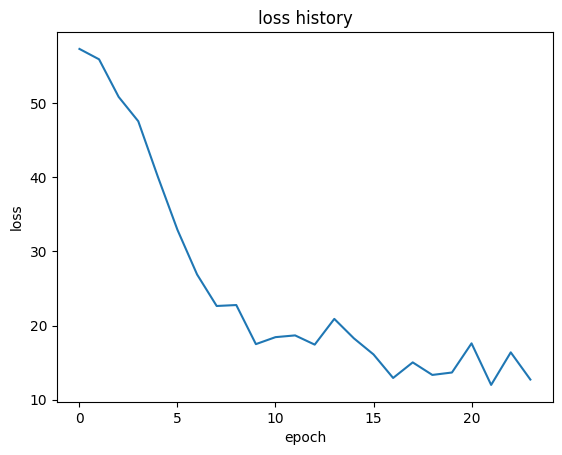

In [ ]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       980
           1       0.91      0.94      0.92      1135
           2       0.93      0.80      0.86      1032
           3       0.81      0.88      0.84      1010
           4       0.95      0.81      0.87       982
           5       0.88      0.62      0.73       892
           6       0.88      0.89      0.89       958
           7       0.86      0.86      0.86      1028
           8       0.56      0.91      0.70       974
           9       0.87      0.77      0.82      1009

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.84      0.84     10000



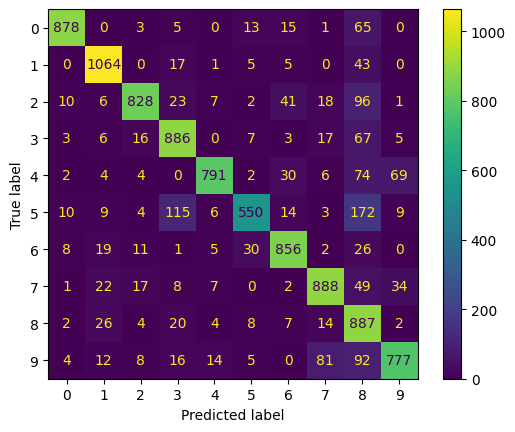

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = []
for i in range(len(test_x)):
    y_pred.append(network.forward(test_x[i].reshape((1, 28, 28)))[0])

y_pred_classes = [x for x in np.argmax(y_pred, axis=1)]
y_true_classes = [x for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)